In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.experimental import optimizers
from jax.experimental.ode import odeint

%load_ext autoreload
%autoreload 2

import interface
import normalization
from neural_networks.fully_connected import FC
from neural_networks.h2mgnode import H2MGNODE

/Users/balthazardonon/Desktop/PostDoc/MLT4PS/ENV/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


# Defining a series of normalizing functions

The features contained in power systems objects may have very different orders of magnitude and display complex distributions with possibly multiple modes. For this reason, it is very important to build a series of functions that can convert those atypical distributions into something that looks more like a uniform law between $-1$ and $1$.

This normalization process is done by computing a piecewise linear approximation of the cumulative distribution function of each required feature. This estimation is estimated by considering a subset of the trainset. This estimation does not need to be perfect, so it seems reasonable to estimate it over a reasonably small amount of samples (see option *amount_of_samples*).

In [2]:
normalizer_options = {
    'data_dir': 'dataset_118/train',
    'features': {
        'bus': ['v_mag', 'v_angle'],
        'gen': ['target_p', 'min_p', 'max_p', 'min_q', 'max_q', 'target_v', 'target_q', 'voltage_regulator_on',
                'p', 'q', 'i', 'connected'],
        'load': ['p0', 'q0', 'p', 'q', 'i', 'connected'],
        'shunt': ['g', 'b', 'voltage_regulation_on', 'target_v', 'connected'],
        'linear_shunt_compensator_sections': ['g_per_section', 'b_per_section'],
        'line': ['r', 'x', 'g1', 'b1', 'g2', 'b2', 'p1', 'q1', 'i1', 'p2', 'q2', 'i2', 'connected1', 'connected2'],
        'twt': ['r', 'x', 'g', 'b', 'rated_u1', 'rated_u2', 'rated_s', 'p1', 'q1', 'i1', 'p2', 'q2', 'i2',
                'connected1', 'connected2']
    },
    'break_points': 200,
    'shuffle': True,
    'amount_of_samples': 100
}
my_normalizer = normalization.Normalizer(normalizer_options)
my_normalizer.save('my_normalizer.pkl')

Loading all the dataset: 100%|████████████████| 100/100 [00:07<00:00, 13.99it/s]


# Defining an iterator

In order to have our neural network learn, we have to pass it multiple batches of instances of power grids. The iterator will thus iterate over the whole dataset defined in *data_dir*, and return both an input $x$ that will be read by the neural network, and a series of pypowsybl networks instances.

As some people may be interested in dealing with time series, we have included the possibility of considering rolling windows.

In [3]:
iterator_options = {
    'data_dir': 'dataset_118',
    'addresses': {
        'bus': ['id'],
        'gen': ['bus_id'],
        'load': ['bus_id'],
        'shunt': ['id', 'bus_id'],
        'line': ['bus1_id', 'bus2_id'],
        'twt': ['bus1_id', 'bus2_id'],
        'linear_shunt_compensator_sections': ['id']
    },
    'features': {
        'bus': ['v_mag', 'v_angle'],
        'gen': ['target_p', 'min_p', 'max_p', 'min_q', 'max_q', 'target_v', 'target_q', 'voltage_regulator_on',
                'p', 'q', 'i', 'connected'],
        'load': ['p0', 'q0', 'p', 'q', 'i', 'connected'],
        'shunt': ['g', 'b', 'voltage_regulation_on', 'target_v', 'connected'],
        'linear_shunt_compensator_sections': ['g_per_section', 'b_per_section'],
        'line': ['r', 'x', 'g1', 'b1', 'g2', 'b2', 'p1', 'q1', 'i1', 'p2', 'q2', 'i2', 'connected1', 'connected2'],
        'twt': ['r', 'x', 'g', 'b', 'rated_u1', 'rated_u2', 'rated_s', 'p1', 'q1', 'i1', 'p2', 'q2', 'i2',
                'connected1', 'connected2']
    },
    'batch_size': 10,
    'shuffle': True,
    'series_length':1,
    'time_window': 1,
    'validation_portion': [0.9, 1.] # Keep the last 10% of data for the validation set
}
my_interface = interface.Interface(iterator_options)

# Defining a simple Fully Connected Neural Network

In the following, we define a simple fully connected neural network.
It has been designed to input and output dictionnaries that respect the data formalism previously introduced.
Because it can only work on data that have a constant size, it is mandatory to define the dimension of the input and output features.
As it cannot exploit the graph structure of the data, it does not make use of the adresses contained in $x$.

The option *hidden_dimensions* defines the dimension of the hidden variables.

In this case, we ask the neural network to output a prediction for active flow in line origins, knowing the active and reactive power of loads, and target power and target voltage of generators.

In [4]:
fully_connected_options = {
    'input_features': {
        'load': {'p0': [99, 1], 'q0': [99, 1]},
        'gen': {'target_p': [54, 1], 'target_v': [54, 1]},
        'shunt': {'g': [14, 1], 'b': [14, 1]}
    },
    'output_features': {
        'bus': {'v_mag': [118, 1]}
    },
    'key': random.PRNGKey(1),
    'hidden_dimensions': [64, 64]
}
my_fully_connected = FC(fully_connected_options)

In [5]:
class PostProcessor:
    def __init__(self):
        pass
    def __call__(self, y):
        return {'bus': {'v_mag': self.line_p1(y['bus']['v_mag'])}}
    def line_p1(self, y):
        return 1.+y
my_postprocessor = PostProcessor()

The following defines the loss function, which penalizes the discrepancy between the prediction of the neural network and the actual solution found using a power flow solver.

In [6]:
def loss(params, x, y):
    y_hat = my_fully_connected.batch_forward(params, x)
    y_post = my_postprocessor(y_hat)
    loss_mag = jnp.mean((y_post['bus']['v_mag'] - y['bus']['v_mag'])**2)
    return loss_mag

@jit
def update(params, x, y, opt_state):
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [7]:
step_size = 1e-2
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(my_fully_connected.weights)

The following defines the training loop that will iteratively pass through the train set and update the neural network weights accordingly.

In [8]:
for epoch in range(5):
    
    # Training loop
    train_pbar = tqdm(my_interface.train)
    train_losses = []
    for a, x, nets in train_pbar:
        x_norm = my_normalizer(x)
        my_interface.compute_load_flow(nets)
        y_truth = my_interface.get_features(nets, {'bus':['v_mag']})
        my_fully_connected.weights, opt_state, train_loss = update(my_fully_connected.weights, x_norm, y_truth, opt_state)
        train_losses.append(train_loss)
        train_pbar.set_description("Epoch {}, Train loss = {:.2e}".format(epoch, train_loss))
        
    # Compute metrics over validation set
    val_pbar = tqdm(my_interface.val)
    val_losses = []
    for a, x, nets in val_pbar:
        x_norm = my_normalizer(x)
        my_interface.compute_load_flow(nets)
        y_truth = my_interface.get_features(nets, {'bus':['v_mag']})
        val_loss = loss(my_fully_connected.weights, x_norm, y_truth)
        val_losses.append(val_loss)
    print("Epoch {}".format(epoch))
    print("    Train mean loss = {:.2e}".format(np.mean(train_losses)))
    print("    Validation mean loss = {:.2e}".format(np.mean(val_losses)))

100%|███████████████████████████████████████████| 50/50 [00:42<00:00,  1.18it/s]


Epoch 0
    Train mean loss = 1.59e-03
    Validation mean loss = 5.52e-06


100%|███████████████████████████████████████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch 1
    Train mean loss = 4.85e-06
    Validation mean loss = 1.53e-06


100%|███████████████████████████████████████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch 2
    Train mean loss = 3.33e-06
    Validation mean loss = 3.54e-06


100%|███████████████████████████████████████████| 50/50 [00:40<00:00,  1.25it/s]


Epoch 3
    Train mean loss = 2.80e-06
    Validation mean loss = 2.07e-06


100%|███████████████████████████████████████████| 50/50 [00:40<00:00,  1.25it/s]

Epoch 4
    Train mean loss = 7.66e-06
    Validation mean loss = 2.03e-05


# Compute metrics over the Test set

In [9]:
losses = []
maes = []

test_pbar = tqdm(my_interface.test)
for a, x, nets in test_pbar:
    
    # Perform prediction
    x_norm = my_normalizer(x)
    y_hat = my_fully_connected.batch_forward(my_fully_connected.weights, x_norm)
    y_post = my_postprocessor(y_hat)

    # Get ground truth
    my_interface.compute_load_flow(nets)
    y_truth = my_interface.get_features(nets, {'bus':['v_mag']})
    
    # Compute metrics
    loss = np.mean((y_post['bus']['v_mag'] - y_truth['bus']['v_mag'])**2, axis=[1,2])
    mae = np.mean(np.mean(np.abs(y_post['bus']['v_mag'] - y_truth['bus']['v_mag']), axis=2), axis=1)
    losses.extend(list(loss))
    maes.extend(list(mae))
    
print('Loss')
print('    max        = {:.2e}'.format(np.max(losses)))
print('    90th perc. = {:.2e}'.format(np.percentile(losses, 90)))
print('    50th perc. = {:.2e}'.format(np.percentile(losses, 50)))
print('    10th perc. = {:.2e}'.format(np.percentile(losses, 10)))
print('    min        = {:.2e}'.format(np.min(losses)))
print('')
print('MAE')
print('    max        = {:.2e}'.format(np.max(maes)))
print('    90th perc. = {:.2e}'.format(np.percentile(maes, 90)))
print('    50th perc. = {:.2e}'.format(np.percentile(maes, 50)))
print('    10th perc. = {:.2e}'.format(np.percentile(maes, 10)))
print('    min        = {:.2e}'.format(np.min(maes)))

100%|█████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]

Loss
    max        = 6.69e-03
    90th perc. = 4.74e-03
    50th perc. = 2.52e-03
    10th perc. = 1.78e-03
    min        = 1.74e-03

MAE
    max        = 7.34e-03
    90th perc. = 6.29e-03
    50th perc. = 4.55e-03
    10th perc. = 3.85e-03
    min        = 3.73e-03


# Plot prediction against ground truth

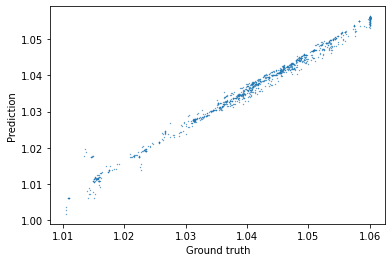

In [10]:
a, x, nets = next(iter(my_interface.test))

# Perform prediction
x_norm = my_normalizer(x)
y_hat = my_fully_connected.batch_forward(my_fully_connected.weights, x_norm)
y_post = my_postprocessor(y_hat)
y_post = np.reshape(y_post['bus']['v_mag'], [-1])

# Get ground truth
my_interface.compute_load_flow(nets)
y_truth = my_interface.get_features(nets, {'bus':['v_mag']})
y_truth = np.reshape(y_truth['bus']['v_mag'], [-1])

# Compare results
plt.scatter(y_truth, y_post, s=0.1)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.show()

# Defining a Hyper Heterogeneous Multi Graph Neural Ordinary Differential Equation (H2MGNODE)

In [19]:
h2mgnode_options = {
    'random_key': random.PRNGKey(1),
    'addresses': {
        'bus': ['id'],
        'gen': ['bus_id'],
        'load': ['bus_id'],
        'shunt': ['id', 'bus_id'],
        'linear_shunt_compensator_sections': ['id'],
        'line': ['bus1_id', 'bus2_id'],
        'twt': ['bus1_id', 'bus2_id']
    },
    'input_features': {
        'gen': ['target_p', 'min_p', 'max_p', 'min_q', 'max_q', 'target_v', 'target_q', 'voltage_regulator_on',
                'connected'],
        'load': ['p0', 'q0', 'connected'],
        'shunt': ['g', 'b', 'voltage_regulation_on', 'target_v', 'connected'],
        'linear_shunt_compensator_sections': ['g_per_section', 'b_per_section'],
        'line': ['r', 'x', 'g1', 'b1', 'g2', 'b2', 'connected1', 'connected2'],
        'twt': ['r', 'x', 'g', 'b', 'rated_u1', 'rated_u2', 'rated_s', 'connected1', 'connected2']
    },
    'output_features': {
        'bus': ['v_mag']
    },
    'time_window': 1,
    'hidden_dimensions': [8],
    'latent_dimension': 4
}
my_h2mgnode = H2MGNODE(h2mgnode_options)

In [20]:
class PostProcessor:
    def __init__(self):
        pass
    def __call__(self, y):
        return {'bus': {'v_mag': self.bus_v_mag(y['bus']['v_mag'])}}
    def bus_v_mag(self, y):
        return 1.+y
my_postprocessor = PostProcessor()

In [21]:
#def odenet(params, init_state):
#    start_and_final_state = odeint(my_h2mgnode.dynamics, init_state, jnp.array([0., 1.]), params,  
#                                   rtol=1.4e-4, atol=1.4e-4, mxstep=jnp.inf)
#    y_e = my_h2mgnode.decode_output(start_and_final_state, params)
#    return my_postprocessor(y_e)
#batched_odenet = vmap(odenet, in_axes=(None, 0))

def loss(params, init_state, y_truth):
    #y_post = odenet(params, init_state)
    y_hat = my_h2mgnode.batched_odenet(params, init_state)
    y_post = my_postprocessor(y_hat)
    return jnp.mean((y_truth['bus']['v_mag'] - y_post['bus']['v_mag'])**2)

@jit
def update(params, init_state, y_truth, opt_state):
    value, grads = value_and_grad(loss)(params, init_state, y_truth)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [22]:
#def loss(params, init_state, y_truth):
#    start_and_final_state = odeint(my_h2mgnode.dynamics, init_state, jnp.array([0., 1.]), params,  
#                                   rtol=1.4e-4, atol=1.4e-4, mxstep=jnp.inf)
#    y_e = my_h2mgnode.decode_output(start_and_final_state, params)
#    y_post = my_postprocessor(y_e)
#    return jnp.mean((y_truth['bus']['v_mag'] - y_post['bus']['v_mag'])**2)

#@jit
#def update(params, init_state, y_truth, opt_state):
#    value, grads = value_and_grad(loss)(params, init_state, y_truth)
#    opt_state = opt_update(0, grads, opt_state)
#    return get_params(opt_state), opt_state, value

In [23]:
step_size = 1e-2
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(my_h2mgnode.weights)

In [24]:
for epoch in range(5):
    
    # Training loop
    train_pbar = tqdm(my_interface.train)
    train_losses = []
    for a, x, nets in train_pbar:
        
        my_interface.compute_load_flow(nets)
        y_truth = my_interface.get_features(nets, {'bus':['v_mag']})
        #y_truth = my_interface.get_features(nets, {'bus':['v_mag']}, flat=True)
        
        x_norm = my_normalizer(x)
        #init_state = my_h2mgnode.initialize_state(a, x_norm, flat=True)
        init_state = my_h2mgnode.initialize_state(a, x_norm)
        my_h2mgnode.weights, opt_state, train_loss = update(my_h2mgnode.weights, init_state, y_truth, opt_state)
        train_losses.append(train_loss)
        train_pbar.set_description("Epoch {}, Train loss = {:.2e}".format(epoch, train_loss))
    
    # Compute metrics over validation set
    val_pbar = tqdm(my_interface.val)
    val_losses = []
    for a, x, nets in val_pbar:
        my_interface.compute_load_flow(nets)
        y_truth = my_interface.get_features(nets, {'bus':['v_mag']})
    
        x_norm = my_normalizer(x)
        init_state = my_h2mgnode.initialize_state(a, x_norm)
        val_loss = loss(my_h2mgnode.weights, init_state, y_truth)
        val_losses.append(val_loss)
    print("Epoch {}".format(epoch))
    print("    Train mean loss = {:.2e}".format(np.mean(train_losses)))
    print("    Validation mean loss = {:.2e}".format(np.mean(val_losses)))

100%|███████████████████████████████████████████| 50/50 [00:57<00:00,  1.14s/it]


Epoch 0
    Train mean loss = 2.71e-05
    Validation mean loss = 4.48e-06


100%|███████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]


Epoch 1
    Train mean loss = 2.09e-06
    Validation mean loss = 1.94e-06


100%|███████████████████████████████████████████| 50/50 [00:50<00:00,  1.02s/it]


Epoch 2
    Train mean loss = 1.05e-06
    Validation mean loss = 1.12e-06


100%|███████████████████████████████████████████| 50/50 [00:47<00:00,  1.06it/s]


Epoch 3
    Train mean loss = 6.95e-07
    Validation mean loss = 8.34e-07


100%|███████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it]

Epoch 4
    Train mean loss = 5.45e-07
    Validation mean loss = 9.22e-07


# Compute metrics

In [25]:
losses = []
maes = []

pbar = tqdm(my_interface.test)
for a, x, nets in pbar:
    
    # Perform prediction
    x_norm = my_normalizer(x)
    y_hat = my_h2mgnode.batch_forward(my_h2mgnode.weights, a, x_norm)
    y_post = my_postprocessor(y_hat)

    # Get ground truth
    my_interface.compute_load_flow(nets)
    y_truth = my_interface.get_features(nets, {'bus':['v_mag']})
    
    # Compute metrics
    loss = (y_post['bus']['v_mag'] - y_truth['bus']['v_mag'])**2
    mae = np.abs(y_post['bus']['v_mag'] - y_truth['bus']['v_mag'])
    losses.extend(list(loss))
    maes.extend(list(mae))
    
print('Loss')
print('    max        = {:e}'.format(np.max(losses)))
print('    90th perc. = {:e}'.format(np.percentile(losses, 90)))
print('    50th perc. = {:e}'.format(np.percentile(losses, 50)))
print('    10th perc. = {:e}'.format(np.percentile(losses, 10)))
print('    min        = {:e}'.format(np.min(losses)))
print('')
print('MAE')
print('    max        = {:e}'.format(np.max(maes)))
print('    90th perc. = {:e}'.format(np.percentile(maes, 90)))
print('    50th perc. = {:e}'.format(np.percentile(maes, 50)))
print('    10th perc. = {:e}'.format(np.percentile(maes, 10)))
print('    min        = {:e}'.format(np.min(maes)))

100%|█████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]

Loss
    max        = 1.712496e-05
    90th perc. = 1.782960e-06
    50th perc. = 2.254451e-07
    10th perc. = 8.249283e-09
    min        = 0.000000e+00

MAE
    max        = 4.138231e-03
    90th perc. = 1.335275e-03
    50th perc. = 4.748106e-04
    10th perc. = 9.082556e-05
    min        = 0.000000e+00


# Plot prediction against ground truth

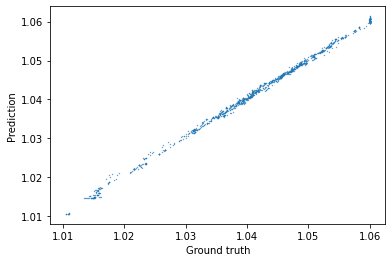

In [26]:
a, x, nets = next(iter(my_interface.test))
x_norm = my_normalizer(x)
y_hat = my_h2mgnode.batch_forward(my_h2mgnode.weights, a, x_norm)
y_post = my_postprocessor(y_hat)

# Get ground truth
my_interface.compute_load_flow(nets)
y_truth = my_interface.get_features(nets, {'bus': ['v_mag']})

# Compare results
plt.scatter(y_truth['bus']['v_mag'], y_post['bus']['v_mag'], s=0.1)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.show()

# Plot the evolution of latent variables

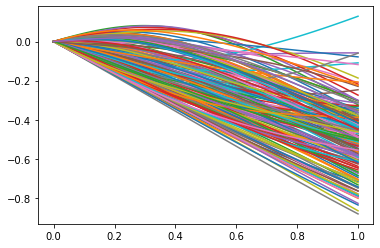

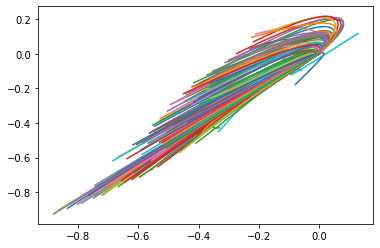

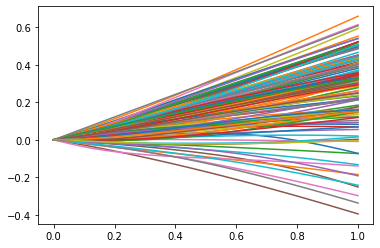

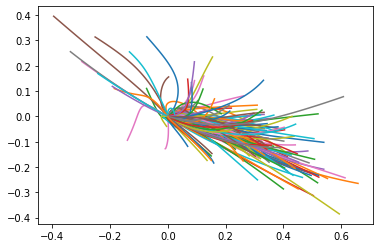

In [27]:
start_and_end_times = jnp.linspace(0., 1., 100)
def odenet(params, init_state):
    intermediate_states = odeint(my_h2mgnode.dynamics, init_state, start_and_end_times, params)
    return intermediate_states
batched_odenet = vmap(odenet, in_axes=(None, 0))
    
a, x, nets = next(iter(my_interface.test))
x_norm = my_normalizer(x)
init_state = my_h2mgnode.initialize_state(a, x_norm)
intermediate_states = batched_odenet(my_h2mgnode.weights, init_state)

y_plot = intermediate_states['h_e']['line'][0,:,:,0]
plt.plot(start_and_end_times, y_plot)
plt.show()

x_plot = intermediate_states['h_e']['line'][0,:,:,0]
y_plot = intermediate_states['h_e']['line'][0,:,:,2]
plt.plot(x_plot, y_plot)
plt.show()

y_plot = intermediate_states['h_v'][0,:,:,0]
plt.plot(start_and_end_times, y_plot)
plt.show()

x_plot = intermediate_states['h_v'][0,:,:,0]
y_plot = intermediate_states['h_v'][0,:,:,1]
plt.plot(x_plot, y_plot)
plt.show()